### Predicting the price range from various factors:

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pymongo import MongoClient
import warnings
warnings.filterwarnings("ignore")

In [15]:
def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]


def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """

    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

In [16]:
df = read_mongo('restaurants', 'zomato_all')
df_CC = read_mongo('restaurants', 'country_codes')

In [17]:
df.rename(columns = {'Country Code': 'Country_code', 'Aggregate rating':'Aggregate_rating', 'Has Table booking': 'Has_table_booking', 'Has Online delivery': 'Has_online_delivery', 'Is delivering now':'Is_delivering_now', 
                          'Switch to order menu' : 'Switch_to_order_menu', 'Average Cost for two' : 'Average_cost_for_two', 'Price range' : 'Price_range', 'Rating color' : 'Rating_color', 'Rating text' : 'Rating_text', 'Restaurant ID':'Restaurant_ID', 'Restaurant Name':'Restaurant_name', 'Locality Verbose':'Locality_verbose'}, inplace = True)

In [18]:
df = df[['Restaurant_ID', 'Restaurant_name', 'Country_code', 'City', 'Address', 'Locality', 'Locality_verbose', 'Longitude', 'Latitude', 'Cuisines', 'Average_cost_for_two', 'Currency', 'Has_table_booking', 'Has_online_delivery', 'Is_delivering_now', 'Switch_to_order_menu', 'Price_range', 'Aggregate_rating', 'Rating_color', 'Rating_text', 'Votes']]

In [19]:
df_orig = df;

In [20]:
df.head(1)

,Restaurant_ID,Restaurant_name,Country_code,City,Address,Locality,Locality_verbose,Longitude,Latitude,Cuisines,...,Currency,Has_table_booking,Has_online_delivery,Is_delivering_now,Switch_to_order_menu,Price_range,Aggregate_rating,Rating_color,Rating_text,Votes
0,6318506,Ooma,162,Mandaluyong City,"Third Floor, Mega Fashion Hall, SM Megamall, O...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.056475,14.585318,"Japanese, Sushi",...,Botswana Pula(P),No,No,No,No,4,4.9,Dark Green,Excellent,365


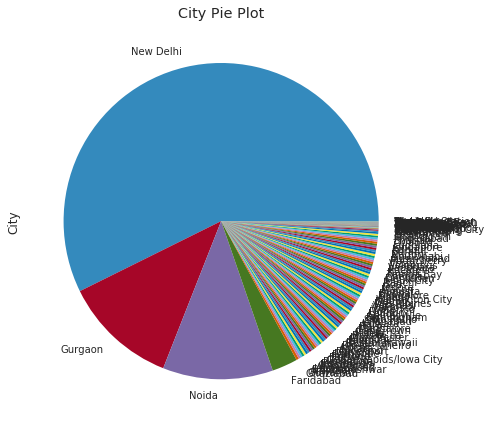

In [21]:
with plt.style.context(('bmh')):
    plt.figure(figsize = (24,16))  # Keep 3:2
    ax = plt.subplot2grid((2,3), (0,0))
    cnt = df['City'].value_counts()
    cnt.plot.pie(ax = ax)
    ax.set_title('City Pie Plot')

#### Removing the restaurants with cities having less than 10 frequency --------- (nd! )

In [22]:
# Cities more than 10 freq only

In [23]:
df['Cuisines'].head()

0                     Japanese, Sushi
1                    Japanese, Korean
2          French, Japanese, Desserts
3                            Japanese
4    Seafood, Asian, Filipino, Indian
Name: Cuisines, dtype: object

#### Getting the cuisines separately in a word list, then creating a dataframe out of it.

In [24]:
cuisines_wordlist = []
cuisines_count = df['Cuisines'].count()
for i in range(cuisines_count):
    cuisines_wordlist.append( df['Cuisines'].tolist()[i].split(",") )
    
cuisines_wordlist = [ j.strip() for i in cuisines_wordlist for j in i ]
df_cuisines_wordlist = pd.DataFrame({'Cuisine_word':cuisines_wordlist})

In [25]:
df_cuisines_count = df_cuisines_wordlist['Cuisine_word'].value_counts().reset_index()
df_cuisines_count.rename( columns = {'index':'Cuisines', 'Cuisine_word':'Count'}, inplace=True)

# Considering only those cuisines with a count>100

df_cuisines_count = df_cuisines_count.loc[ df_cuisines_count['Count'] > 100 ]
df_cuisines_count.tail(4)

,Cuisines,Count
24,Japanese,135
25,Finger Food,114
26,Raw Meats,114
27,Mediterranean,112


#### Barplot for popular cuisines

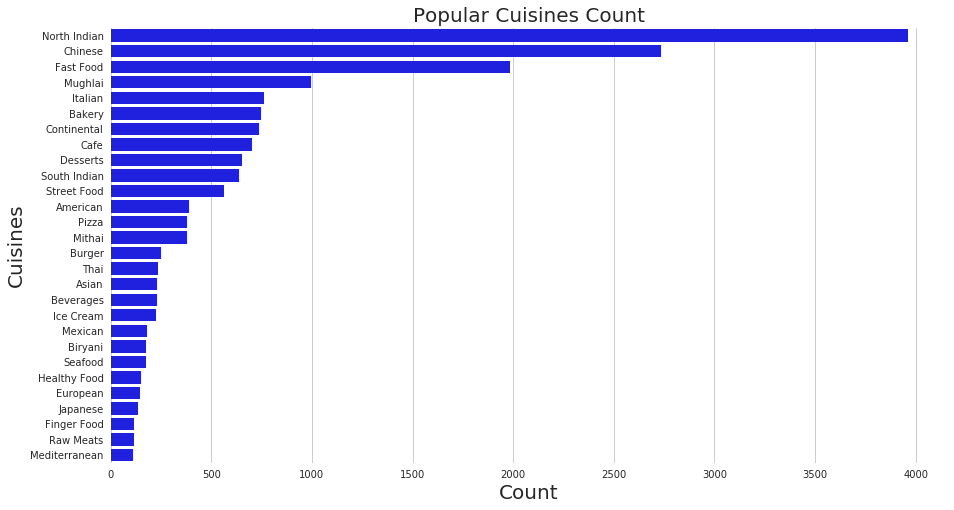

In [26]:
f, ax = plt.subplots(1,1,figsize = (15,8))
sns.set(style="whitegrid")
b = sns.barplot(y = 'Cuisines', x = 'Count', data = df_cuisines_count, color = 'b', ax = ax)

b.axes.set_title("Popular Cuisines Count",fontsize=20)
b.set_xlabel("Count",fontsize=20)
b.set_ylabel("Cuisines",fontsize=20)

sns.despine(left=True, bottom=True)
plt.show()

#### Correlation matrix for the dataset

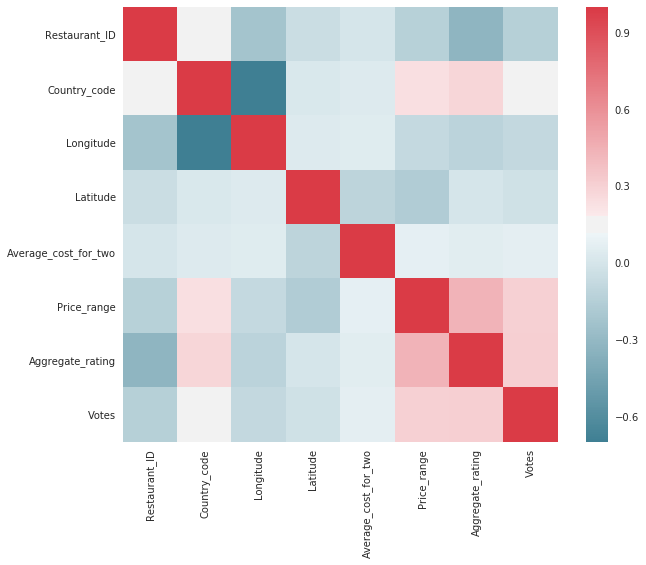

In [27]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

#### Observations:
1. Price range and aggregate rating  are positively co-related
2. Price range and votes are also positively co-related

It is thus possible to build <b>a model which predicts the Price Range of a restaurant</b> based on the Aggregate Rating and Votes obtained by that restaurant

#### Part 1: Data cleaning and preparation

1. Removing the restaurants with votes <  20
2. Removing the restaurants with Average_cost_for_two < 1

In [28]:
#Initially
df['Restaurant_ID'].count()

9551

In [29]:
df = df.loc[ df['Votes'] > 20 ]

In [30]:
df['Restaurant_ID'].count()

5418

In [31]:
df = df.loc[ df['Average_cost_for_two'] > 1 ]

In [32]:
df['Restaurant_ID'].count()

5401

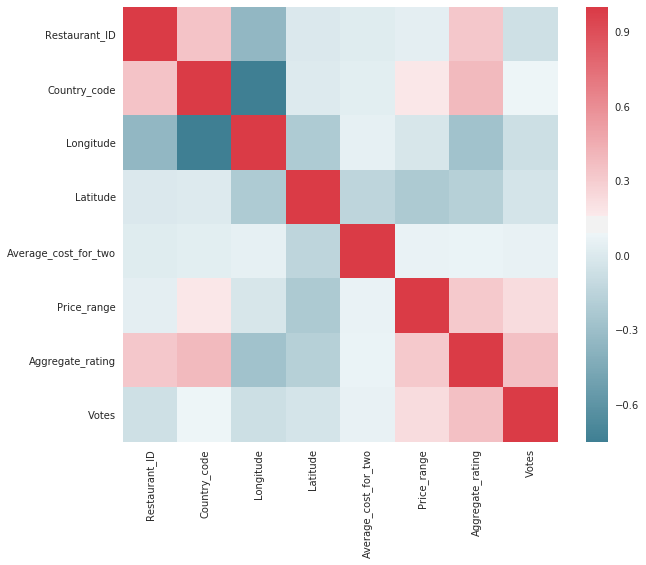

In [33]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

#### Prediciting the price range using a Generalized Linear Model

In [34]:
df_train = df[:-20]
df_test = df[-20:]
df_test = df_test['Aggregate_rating']

In [35]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

res = smf.glm('Price_range ~ Aggregate_rating + Votes', df_train).fit()
res.summary()

#df_predictions = res.predict(df_test).reset_index()
#df_predictions


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            Price_range   No. Observations:                 5381
Model:                            GLM   Df Residuals:                     5378
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                  0.763503598928
Method:                          IRLS   Log-Likelihood:                -6907.8
Date:                Thu, 19 Apr 2018   Deviance:                       4106.1
Time:                        08:59:11   Pearson chi2:                 4.11e+03
No. Iterations:                     2                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.4503      0.082      5.516      0.000       0.290       0.610
Aggregate_rating     0.4586      0.023     19.868      0.000       0.413       0.504
Votes                0.0002   2.34e-05      9.772      0.000       0.000       0.000
====================================================================================
"""

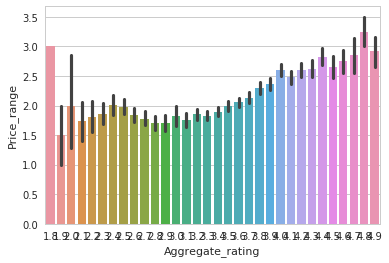

In [60]:
sns.set_style("whitegrid")
sns.barplot(x="Aggregate_rating", y="Price_range", data=df);

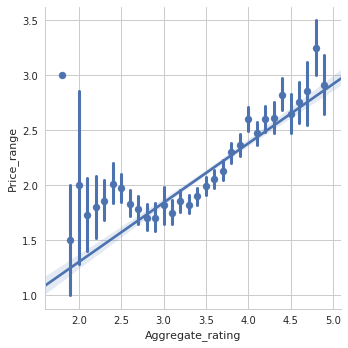

In [61]:
sns.lmplot(x="Aggregate_rating", y="Price_range", data=df, x_estimator=np.mean)

In [62]:
#df_X = df[['Aggregate_rating', 'Votes']]
df_X = df['Aggregate_rating']

### Price range prediction using a Bayesian model

In [38]:
df1=pd.concat([df[['Average_cost_for_two','Aggregate_rating','Price_range']]],axis=1)
df1.head()

,Average_cost_for_two,Aggregate_rating,Price_range
0,1500,4.9,4
1,1500,4.8,4
2,1100,4.8,3
3,1200,4.5,3
4,4000,4.4,4


In [39]:
df_orig.groupby('Price_range').size()

Price_range
1    4444
2    3113
3    1408
4     586
dtype: int64

In [40]:
x=df1[['Average_cost_for_two','Aggregate_rating']].values
y=df1.Price_range
type(x)
type(y)
x.shape,y.shape

((5401, 2), (5401,))

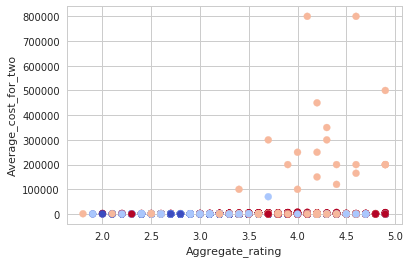

In [41]:
def visualize_data():
    plt.scatter(x[:,1],x[:,0],c=y,cmap=plt.cm.coolwarm)
    plt.xlabel('Aggregate_rating')
    plt.ylabel('Average_cost_for_two')
    plt.show()
visualize_data()

In [53]:
from sklearn.cross_validation import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((4050, 2), (1351, 2), (4050,), (1351,))

In [54]:
from sklearn.naive_bayes import MultinomialNB
clf=MultinomialNB()

In [55]:
clf.fit(x_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [56]:
y_pred= clf.predict(x_test)
print(y_pred)

[2 2 2 ..., 2 4 2]


In [57]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.55      0.62      0.58       330
          2       0.62      0.89      0.73       571
          3       0.24      0.04      0.07       327
          4       0.32      0.27      0.29       123

avg / total       0.48      0.56      0.49      1351



In [58]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
accuracy_score(y_test, y_pred)

0.56106587712805334

[[203 127   0   0]
 [ 63 508   0   0]
 [ 67 175  14  71]
 [ 34  11  45  33]]


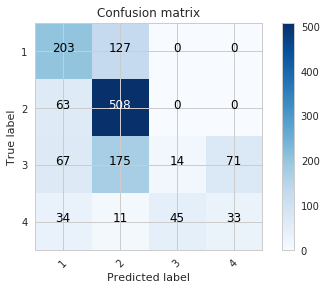

In [59]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4],
                      title='Confusion matrix')


plt.show()
